### Regression and Dimensionality Reduction

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

We start with a brief EDA to check for missing values and outliers.

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [3]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


#### Checking for missing data

No obvious missing data such as null values.

In [4]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

#### Examine Categorical Data

In [5]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [6]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [7]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [8]:
# Change categorical data to binary data.

gender_mapper = {'male': 1, 'female':0}
smoker_mapper = {'yes': 1, 'no': 0}

df['gender'] = df['gender'].replace(gender_mapper)
df['smoker'] = df['smoker'].replace(smoker_mapper)



In [9]:
# One hot encode region

df = pd.get_dummies(df, columns=['region'], 
                        drop_first=True)

#### Check out numerical attributes

The max value of BMI looks suspiciously high.

In [10]:
df.describe()

,age,gender,bmi,children,smoker,insurance_cost,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428995,0.445181,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000


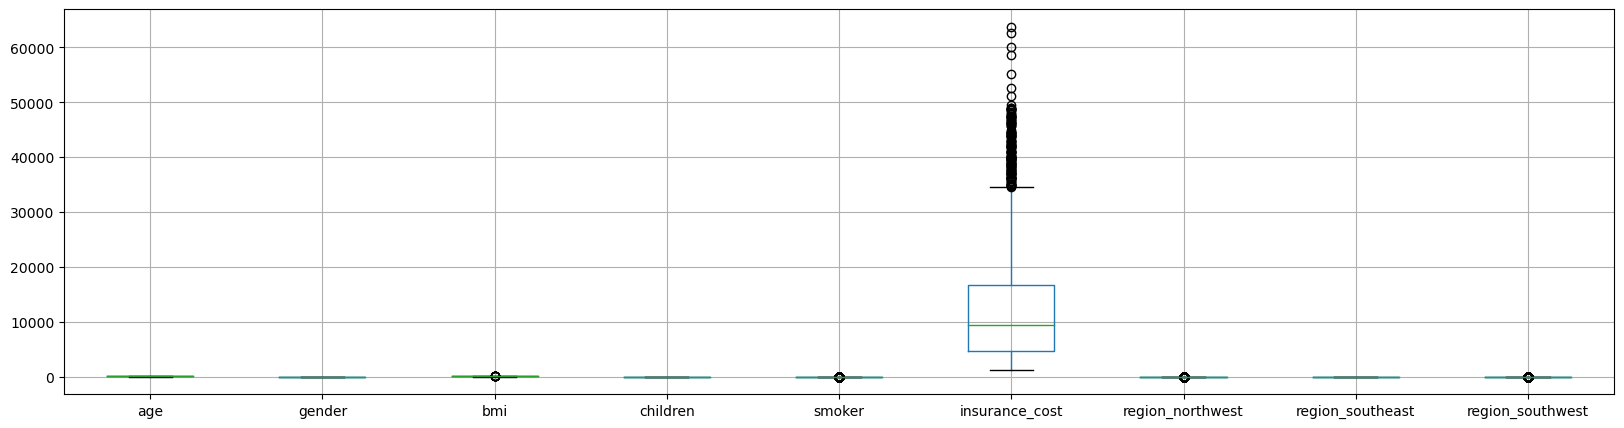

In [11]:
df.boxplot(figsize=(20,5))
plt.show()

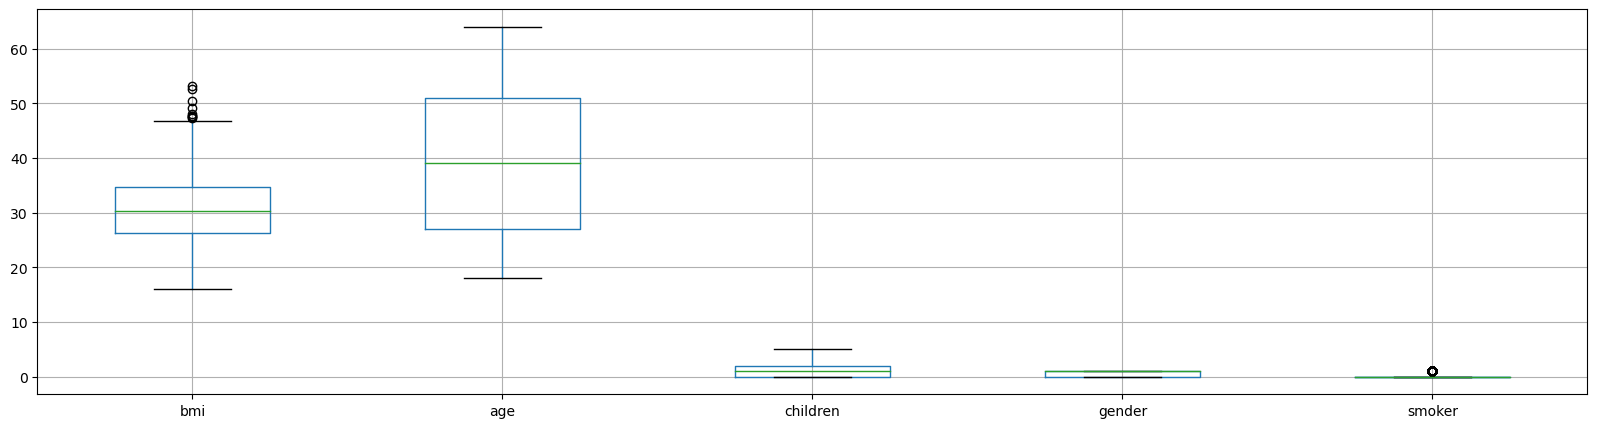

In [12]:
df[['bmi', 'age', 'children', 'gender', 'smoker']].boxplot(figsize=(20,5))
plt.show()

Our target variable insurance_cost has the most outliers.

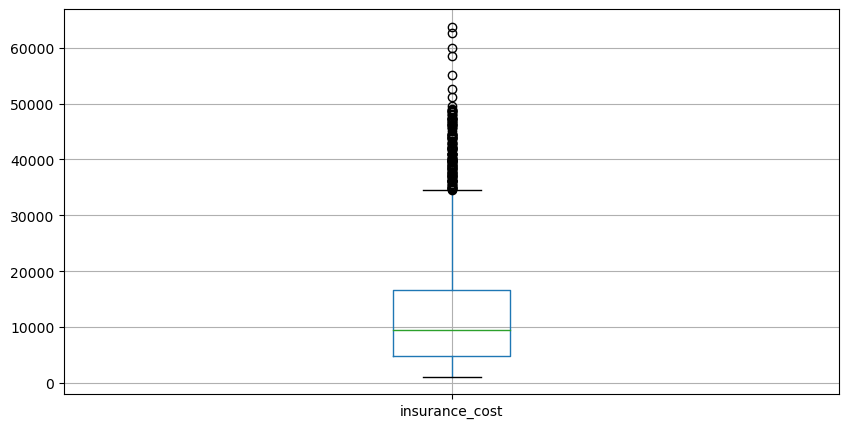

In [13]:
df[['insurance_cost']].boxplot(figsize=(10,5))
plt.show()

Initially I thought that the high values of BMI might be invalid data, however looking at the box plot it is not too far outside the normal range.  

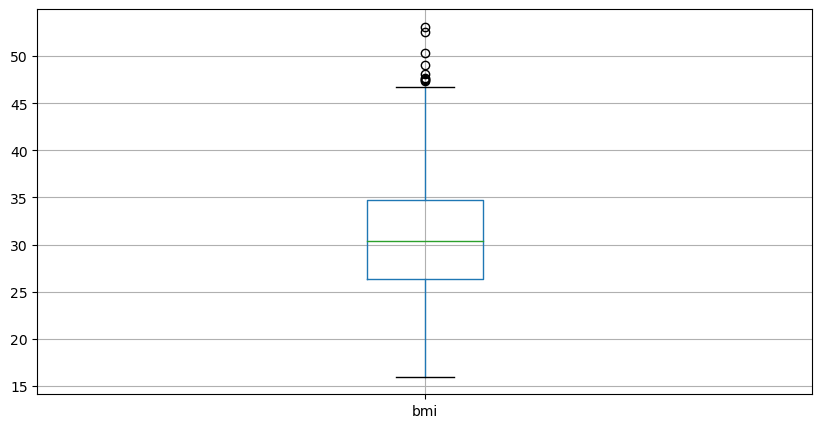

In [14]:
df[['bmi']].boxplot(figsize=(10,5))
plt.show()

As there are outliers make a preprocess pipeline that handles this.

In [15]:
# Define a custom transformer class 'AddColumnNames' which inherits from BaseEstimator and TransformerMixin classes
class AddColumnNames(BaseEstimator, TransformerMixin):

    # Initialize the class object with input parameter 'columns'
    def __init__(self, columns):
        self.columns = columns

    # Define the fit method that returns 'self'
    def fit(self, X, y=None):
        return self

    # Define the transform method to add column names to the input data and return as pandas dataframe
    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [16]:
# Define a custom transformer class 'ColumnSelector' which inherits from BaseEstimator and TransformerMixin classes
class ColumnSelector(BaseEstimator, TransformerMixin):

    # Initialize the class object with input parameter 'columns'
    def __init__(self, columns):
        self.columns = columns

    # Define the fit method that returns 'self'
    def fit(self, X, y=None):
        return self

    # Define the transform method to select the specified columns from the input data
    def transform(self, X):
        # Check if input is a pandas dataframe
        assert isinstance(X, pd.DataFrame)
        # Select the specified columns from the input data and return as pandas dataframe
        return X[self.columns]

This step creates lists for features that have outliers and features that do not. 

These will be treated differently in the preprocessing pipeline.

In [17]:
# Create a list of all column names except 'insurance_cost' our target variable
names_all = list(df.drop(['insurance_cost'], axis=1).columns)

# Define column groups with same data preparation
# Create a list of column names to be treated as outliers
names_outliers = ['bmi']
# Create a list of column names to be treated without outliers (using set difference operation)
names_no_outliers = list(set(names_all) - set(names_outliers))

In [18]:
# Define a pre-processing pipeline to transform input data
preprocess_pipeline = make_pipeline(
    # AddColumnNames transformer adds column names to input data
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        # Pipeline for columns with outliers
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),# Select specified columns
            FunctionTransformer(np.log, validate=True),# Logarithmic transformation
            RobustScaler()# Scale the data using RobustScaler
        )),
        # Pipeline for columns without outliers
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),# Select specified columns
            StandardScaler()# Scale the data using StandardScaler
        ))
    ])
)

In [19]:
# Separate the target variable and the input features
y = df['insurance_cost']# target variable
X = df.drop('insurance_cost', axis=1).values# input features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Random Forrest
Create a pipeline for processing the Random Forrest model using a grid search.

In [20]:
# Define a scikit-learn pipeline for regression
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),  # Data preprocessing steps
                       ('reduce_dim', 'passthrough'), # Dimensionality reduction step, passthrough means no reduction
                       ('regression', RandomForestRegressor(n_estimators=10))]) # Regression model: RandomForrest

In [21]:
# Define a grid of hyperparameters to search over
N_FEATURES_OPTIONS = [2, 4, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    # Use PCA for dimensionality reduction
    {
        'reduce_dim': [PCA(iterated_power=7)], # Use PCA with 7 iterations for dimensionality reduction
        'reduce_dim__n_components': N_FEATURES_OPTIONS, # Vary number of components to keep
        'regression__max_depth': MAX_DEPTH_OPTIONS # Vary maximum depth of decision trees in random forest
    },
    # Use recursive feature elimination (RFE) with two different models for dimensionality reduction
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())], # Use RFE with two different models for dimensionality reduction
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS, # Vary number of features to keep
        'regression__max_depth': MAX_DEPTH_OPTIONS # Vary maximum depth of decision trees in random forest
    }  
]

# Perform grid search over the hyperparameters defined above
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # Use 5-fold cross-validation for evaluation
search.fit(X_train, y_train) # Fit the search object on training data

# Print best cross-validation score and corresponding hyperparameters
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store the best parameters and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.857:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'regression__max_depth': 4}


### Linear Regression
Create a pipeline for processing the Random Forrest model using a grid search.

In [22]:
# Define a scikit-learn pipeline for regression
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),  # Data preprocessing steps
                       ('reduce_dim', 'passthrough'), # Dimensionality reduction step, passthrough means no reduction
                       ('regression', LinearRegression())]) # Regression model: LinearRegression


In [23]:
# Define a grid of hyperparameters to search over
N_FEATURES_OPTIONS = [2, 4, 6, 8]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    # Use PCA for dimensionality reduction
    {
        'reduce_dim': [PCA(iterated_power=7)], # Use PCA with 7 iterations for dimensionality reduction
        'reduce_dim__n_components': N_FEATURES_OPTIONS  # Vary number of features to keep
    },
    # Use recursive feature elimination (RFE) with two different models for dimensionality reduction
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())], # Use RFE with two different models for dimensionality reduction
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS  # Vary number of features to keep
    }  
]

# Perform grid search over the hyperparameters defined above
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # Use 5-fold cross-validation for evaluation
search.fit(X_train, y_train)# Fit the search object on training data

# Print best cross-validation score and corresponding hyperparameters
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store the best parameters and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.745:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4}


In [24]:
# Define a scikit-learn pipeline for regression
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), # Data preprocessing steps
                       ('reduce_dim', 'passthrough'), # Dimensionality reduction step, passthrough means no reduction
                       ('regression', GradientBoostingRegressor())]) # Regression model: LinearRegression

In [25]:
# Define a grid of hyperparameters to search over
N_FEATURES_OPTIONS = [2, 4, 6, 8]
LEARNING_RATE = [0.1, 0.5, 1]
ESTIMATORS = [50, 100, 200]
MAX_DEPTH_OPTIONS = [3, 5, 7]

param_grid = [    {
    # Define a list of dictionaries that specify the parameter grid to search over
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__learning_rate': LEARNING_RATE,
        'regression__n_estimators': ESTIMATORS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
     # Use recursive feature elimination with linear SVM or linear regression to reduce dimensionality
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__learning_rate': LEARNING_RATE,
        'regression__n_estimators': ESTIMATORS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    }  
]

# Perform grid search over the hyperparameters defined above
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True) # Use 5-fold cross-validation for evaluation
search.fit(X_train, y_train)# Fit the GridSearchCV object to the training data

# Print the best cross-validation score and the corresponding parameters
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store the best parameters and best model for later use
GBR_best_params = search.best_params_
GBR_best_model = search.best_estimator_

Best CV score = 0.858:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regression__learning_rate': 0.1, 'regression__max_depth': 3, 'regression__n_estimators': 50}


### Compare Regression Models

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

In [26]:
def evaluate_model(X_test, y_test, model, iterations=100):
    """
    Evaluates a machine learning model by computing its mean squared error (MSE), mean absolute error (MAE), and 
    R^2 score over a specified number of iterations.
    
    Args:
    X_test (numpy.ndarray): The feature matrix of the test set.
    y_test (numpy.ndarray): The target array of the test set.
    model (estimator object): The machine learning model to be evaluated.
    iterations (int): The number of iterations to perform (default=100).
    
    Returns:
    A tuple of the mean MSE, mean MAE, and mean R^2 score computed over the specified number of iterations.
    """
    # Create empty lists to store the computed metrics
    mse_list = []
    mae_list = []
    r2_list = []

    # Perform the specified number of iterations
    for i in range(iterations):
        # Compute predictions for the test set
        _predicted_values = model.predict(X_test)
        
        # Compute metrics
        _mse = mean_squared_error(y_test, _predicted_values)
        _mae = mean_absolute_error(y_test, _predicted_values)
        _r2 = r2_score(y_test, _predicted_values)
        
        # Append the computed metrics to their respective lists
        mse_list.append(_mse)
        mae_list.append(_mae)
        r2_list.append(_r2)

    # Return the mean of each computed metric       
    return np.mean(mse_list), np.mean(mae_list), np.mean(r2_list)

In [27]:
# Get the average value of model evaluation
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
GBR_mse, GBR_mae, GBR_r2 = evaluate_model(X_test, y_test, GBR_best_model)

# create a dictionary with the results
results_dict = {'MSE': [RF_mse, LR_mse, GBR_mse],
                'MAE': [RF_mae, LR_mae, GBR_mae],
                'R2': [RF_r2, LR_r2, GBR_r2]}

# set the index to the model names
results_df = pd.DataFrame(results_dict, index=['Random Forest', 'Linear Regression', 'Gradient Boosting'])

# display the dataframe with updated column names and index
results_df.rename_axis('Model')


,MSE,MAE,R2
Model,,,
Random Forest,2.098333e+07,2596.932150,0.846614
Linear Regression,3.488195e+07,4051.951103,0.745017
Gradient Boosting,1.982846e+07,2454.237062,0.855056


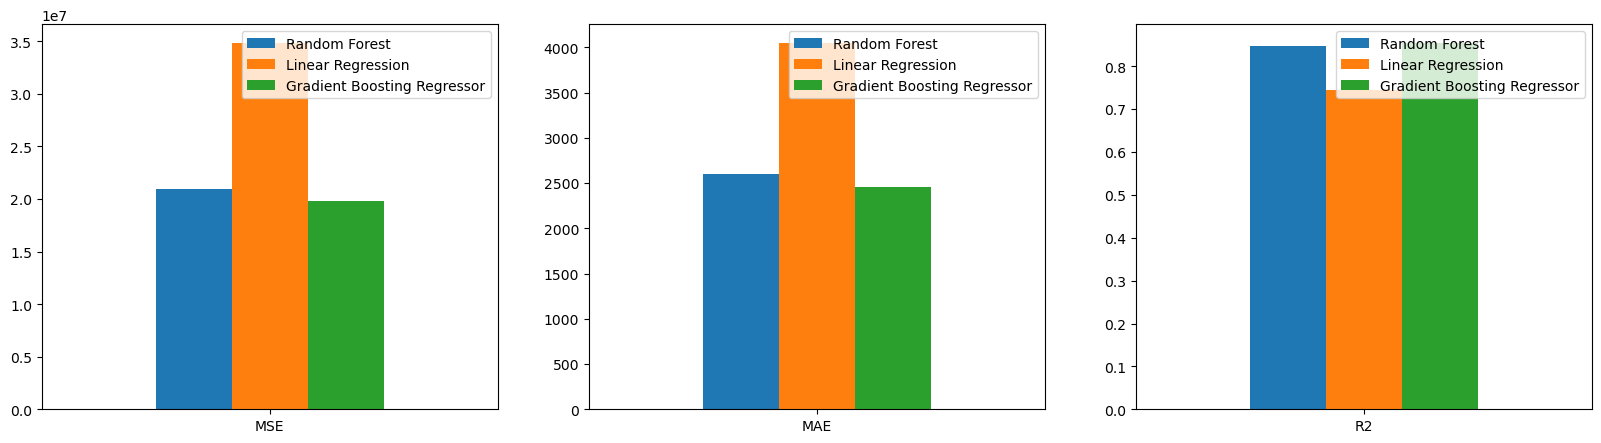

In [28]:
# Plot Comparison data in a bar chart
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Gradient Boosting Regressor': GBR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Gradient Boosting Regressor': GBR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Gradient Boosting Regressor': GBR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

### Compare Regression Models

The MSE and MAE scores measure the average difference between the actual and predicted values. A lower MSE and MAE indicate that the Model's predictions are closer to the actual values, which means the Model is better at accurately predicting the outcome. In this case, both Random Forest and Gradient Boosting have lower MSE and MAE than Linear Regression, indicating that they are better at accurately predicting the outcome.

The R2 score measures how well the Model fits the data or how much of the variance in the outcome variable is explained by the Model. R2 scores range from 0 to 1, with higher values indicating a better fit. In this case, both Random Forest and Gradient Boosting have higher R2 scores than Linear Regression, suggesting that they fit the data better and explain more of the variance in the outcome variable.

Therefore, based on these metrics, we can conclude that Gradient Boosting is the best-performing Model in this case, followed closely by Random Forest. Linear Regression, on the other hand, performed the worst among the three models.

However, the Gradient Boosting Regression seems more computationally expensive as it took significantly longer to execute than either Linear Regression or Random Forrest Regression. As there is only a marginal difference between Gradient Boosting and Random Forrest, I have selected Random Forrest as the best Model.


### Final model Trained and Saved

After selecting RandomForrest as the best model it is trained and save the model to the disk.

In [29]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [30]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

### Isomap & TruncatedSVD

Isomap is a method that helps to represent high-dimensional data more simply, so we can better understand and analyze it. It does this by looking at the distances between data points and creating a map showing the relationships between them in a lower-dimensional space. This helps us to see patterns and structures in the data that might not be clear in the original high-dimensional space.

Truncated SVD is a technique that helps to reduce the number of features or dimensions in a dataset while preserving the most critical information. It works by creating a new set of features that capture the most variation in the data and discarding the less important ones. TruncatedSVD can help simplify the data and make it easier to work while retaining the most critical information.


In [31]:
from sklearn.manifold import Isomap
from sklearn.decomposition import TruncatedSVD

In [32]:
# Define a scikit-learn pipeline for regression
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),  # Data preprocessing steps
                       ('reduce_dim', 'passthrough'), # Dimensionality reduction step, passthrough means no reduction
                       ('regression', LinearRegression())]) # Regression model: LinearRegression

In [33]:
# Define the options for the number of features to reduce to
N_FEATURES_OPTIONS = [2, 4, 6, 8]
NEIGHBORS = [5, 10, 15]

# Define the hyperparameter search space for the pipeline
param_grid = [   
     {
         # Use Isomap for feature reduction with the options for number of components and neighbors to consider
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': NEIGHBORS
    },
    {
        # Use TruncatedSVD for feature reduction with the options for number of components to reduce to
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)# Perform a grid search with 5-fold cross validation and refit the best model
search.fit(X_train, y_train)# Fit the hyperparameter search to the training data

# Print the best cross validation score and hyperparameters
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# Store the best hyperparameters and model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.743:
Best parameters:  {'reduce_dim': TruncatedSVD(n_components=8), 'reduce_dim__n_components': 8}


In [34]:
# Define a scikit-learn pipeline for regression
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),  # Data preprocessing steps
                       ('reduce_dim', 'passthrough'), # Dimensionality reduction step, passthrough means no reduction
                       ('regression', RandomForestRegressor())]) # Regression model: LinearRegression

In [35]:
N_FEATURES_OPTIONS = [2, 4, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
NEIGHBORS = [5, 10, 15]
ESTIMATORS = [50, 100, 200]

param_grid = [    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': NEIGHBORS,
        'regression__n_estimators': ESTIMATORS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__n_estimators': ESTIMATORS,
        'regression__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.804:
Best parameters:  {'reduce_dim': TruncatedSVD(n_components=8), 'reduce_dim__n_components': 8, 'regression__max_depth': 6, 'regression__n_estimators': 200}


In [36]:
# Get the average value of model evaluation
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

# create a dictionary with the results
results_dict = {'MSE': [RF_mse, LR_mse],
                'MAE': [RF_mae, LR_mae],
                'R2': [RF_r2, LR_r2]}

# set the index to the model names
results_df = pd.DataFrame(results_dict, index=['Random Forest', 'Linear Regression'])

# display the dataframe with updated column names and index
results_df.rename_axis('Model')

,MSE,MAE,R2
Model,,,
Random Forest,2.529711e+07,2981.561816,0.815081
Linear Regression,3.528207e+07,4079.673783,0.742093


<AxesSubplot: >

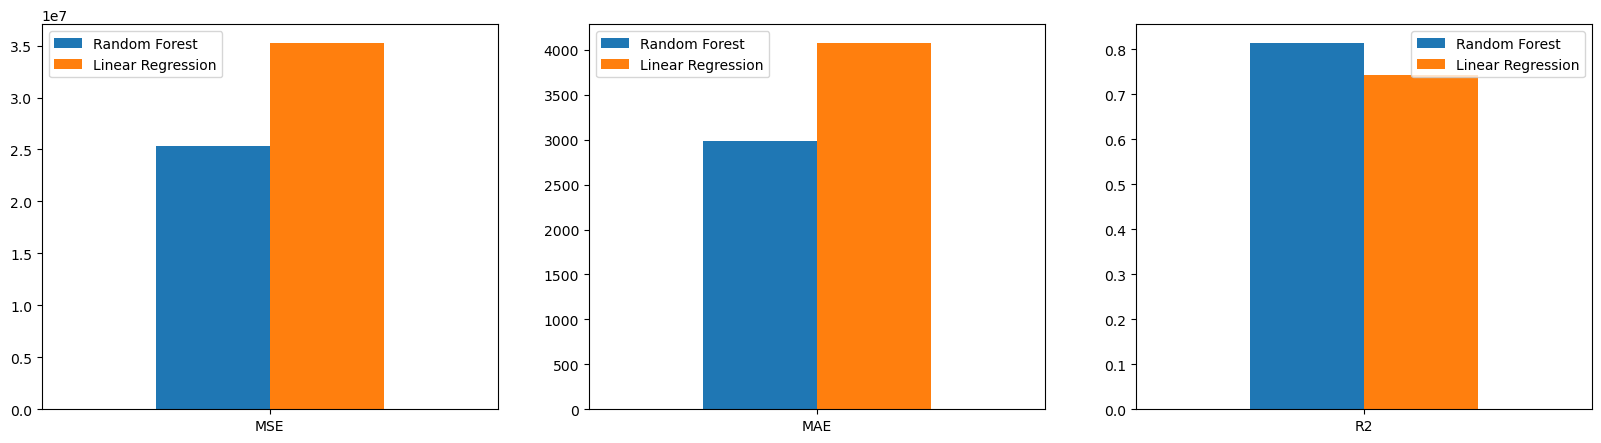

In [37]:
# Plot Comparison data in a bar chart
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])


### Comparison

Isomap and TruncatedSVD are two different techniques used to simplify high-dimensional data for analysis. 

Isomap creates a map showing the relationships between data points in a lower-dimensional space by considering their distances. This helps to reveal patterns and structures that may not be apparent in the original high-dimensional space. 

TruncatedSVD creates a new set of features that capture the most critical information in the data by reducing the number of features or dimensions. This helps to simplify the data while retaining the most critical information. 

When using these two dimensionality reduction techniques Random Forrest again performed better than Linear Regression. 
It was interesting to see that TruncatedSVD was selected as the best form of dimension reduction by GridSearch. 

I think there could be a few reasons for this. Truncated SVD is a linear dimensionality reduction technique, while Isomap is nonlinear. Linear methods may be more appropriate in some cases, especially when the relationships between features in the data are linear or when the data is high-dimensional but not very complex. Nonlinear methods like Isomap may be more useful for data that has complex or nonlinear relationships between features.

Another reason for TruncatedSVD performing better could be my selection of hyperparameters. Isomap has several parameters that need to be tuned when constructing the graph, and I may not have selected the optimal parameters for my specific data. TruncatedSVD, on the other hand, has fewer hyperparameters and may be easier to tune for optimal performance.

